# Investigating Gaussian Processes for di-jet invariant mass fit function

Kyle Cranmer, Meghan Frate, Daniel Whiteson 2015

In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import ExpSquaredKernel, MyLocalGaussianKernel, ExpKernel, MyLocalExpSquared
from scipy.optimize import curve_fit
import triangle
from lmfit import Parameters, minimize, fit_report
import emcee
pl = plt

## Load data

In [3]:
# https://github.com/mfrate28/GuassianProcesses/blob/master/DijetsResiduals.ipynb
# originally from HEPdata
#np.savetxt('dijet_data.csv', (xval, xerrminus, xerrplus, yval, yerr, xerr))

In [4]:
#cut out first 24 bins b/c fits seem crazy there
xval, xerrminus, xerrplus, yval, yerr, xerr = np.loadtxt('dijet_data.csv', usecols=range(24,60))
#scale data by bin width since curve-fit can't have the model take in an argument
#newy = yval/(xerrplus+xerrminus) 

## Define standard CDF dijet fitting function

Notice that curve_fit is a least squares fit and minimize will minimize what is given, but residual_CDF2009 isn't a -logL

In [5]:
def model2_CDF2009(t, params): 
    global xerrplus, xerrminus
    p0, p1, p2, p3 = params
    sqrts = 8000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2+p3*np.log(t/sqrts)))*(xerrplus+xerrminus)

In [6]:
def nll(params, t,data=None): #gaussian distribution
    #prediction = p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2+p3*np.log(t/sqrts))
    prediction = model2_CDF2009(t,params.valuesdict().values() )
    return (prediction-data)/np.sqrt(prediction)

In [7]:
#initialize parameters
fit_params = Parameters()
fit_params.add('p0', value=0.0490546530927)
fit_params.add('p1', value=7.3087377889)
fit_params.add('p2', value=-6.00446454843)
fit_params.add('p3', value=0.1347386042)
#try a different set of parameter values
fit_params['p0'].value = 0.55765009832017132
fit_params['p1'].value = 8.6753672190427995
fit_params['p2'].value = -5.4038968232544793
fit_params['p3'].value = -0.042639640230075333
fit_params

Parameters([('p0', <Parameter 'p0', 0.5576500983201713, bounds=[-inf:inf]>), ('p1', <Parameter 'p1', 8.6753672190428, bounds=[-inf:inf]>), ('p2', <Parameter 'p2', -5.403896823254479, bounds=[-inf:inf]>), ('p3', <Parameter 'p3', -0.04263964023007533, bounds=[-inf:inf]>)])

('do fit', '[[Variables]]\n    p0:   0.55765009 (init= 0.04905465)\n    p1:   8.67536721 (init= 7.308738)\n    p2:  -5.40389682 (init=-6.004465)\n    p3:  -0.04263964 (init= 0.1347386)\n[[Correlations]] (unreported correlations are <  0.100)')


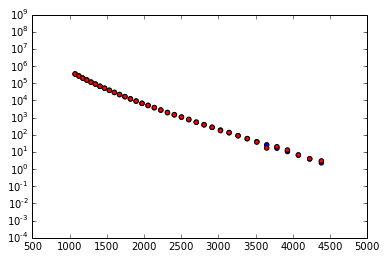

In [8]:
#do fit
out = minimize(nll, fit_params, args=(xval,), kws={'data':yval})

print("do fit", fit_report(fit_params))

plt.scatter(xval, model2_CDF2009(xval,  fit_params.valuesdict().values()))
plt.scatter(xval, yval, c='r')
plt.ylim([10e-5, 10e8])
plt.yscale('log')

(-100.0, 100.0)

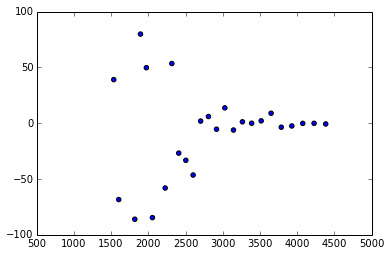

In [9]:
plt.scatter(xval, model2_CDF2009(xval,fit_params.valuesdict().values() )-yval) 
plt.ylim(-1E2,1E2)

## Do MCMC on the CDF fit function

In [10]:
def lnlike_ind(p, t, y, yerr):
    prediction = model2_CDF2009(t,p )
    return -0.5 * np.sum( (prediction-y)*(prediction-y) / prediction) 
    # return p1*math.log(1-t)+(p2+p3*math.log(t)

def lnprior_ind(p):
    p0, p1, p2, p3 = p
    if (0 < p0 < 3 and  0 < p1 < 10 and -10 < p2 < 0 and -1 < p3 < 1):
        return 0.0
    return -np.inf

def lnprob_ind(p, x, y, yerr): 
    lp = lnprior_ind(p) 
    return lp + lnlike_ind(p, x, y, yerr) if np.isfinite(lp) else -np.inf

In [11]:
def fit_ind(initial, data, nwalkers=32):
    ndim = len(initial)
    p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_ind, args=data)
    print("Running burn-in")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()
    
    best_fit = p0[np.argmax(lnp)]
    print best_fit

    #print("Running second burn-in")
    #p = p0[np.argmax(lnp)]
    #p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
    #p0, _, _ = sampler.run_mcmc(p0, 500)
    #sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)
    return sampler, best_fit

In [12]:
np.random.seed(1234)
init_params = fit_params.valuesdict().values()
data = (xval, yval, np.sqrt(yval))

# Fit assuming GP.
print("Fitting ind")
sampler, best_fit = fit_ind(init_params, data)
samples = sampler.flatchain

Fitting ind
Running burn-in
[ 0.70227265  8.73040196 -5.16589499  0.01853028]
Running production


### Look at residuals for some sample curves from the posterior
kind of useless b/c big jumps come from fluctuation of data that no model can accomodate

(-1000, 1000)

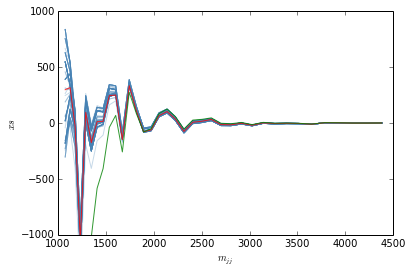

In [13]:
for s in samples[:100]:
    pl.plot(xval, yval-model2_CDF2009(xval,s), color="#4682b4", alpha=0.3)

pl.plot(xval, yval-model2_CDF2009(xval,best_fit), color="r", alpha=0.8)
pl.plot(xval, yval-model2_CDF2009(xval,init_params), color="g", alpha=0.8)

pl.ylabel(r"$xs$")
pl.xlabel(r"$m_{jj}$")
pl.ylim(-1000,1000)


### look at spread about the best fit
more useful b/c it shows how the models vary

(-500, 200)

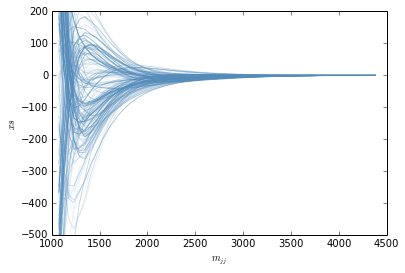

In [14]:
best_fit_model = model2_CDF2009(xval,best_fit)
for s in samples[:1000]:
    pl.plot(xval, best_fit_model-model2_CDF2009(xval,s), color="#4682b4", alpha=0.05)

pl.ylabel(r"$xs$")
pl.xlabel(r"$m_{jj}$")
pl.ylim(-500,200)

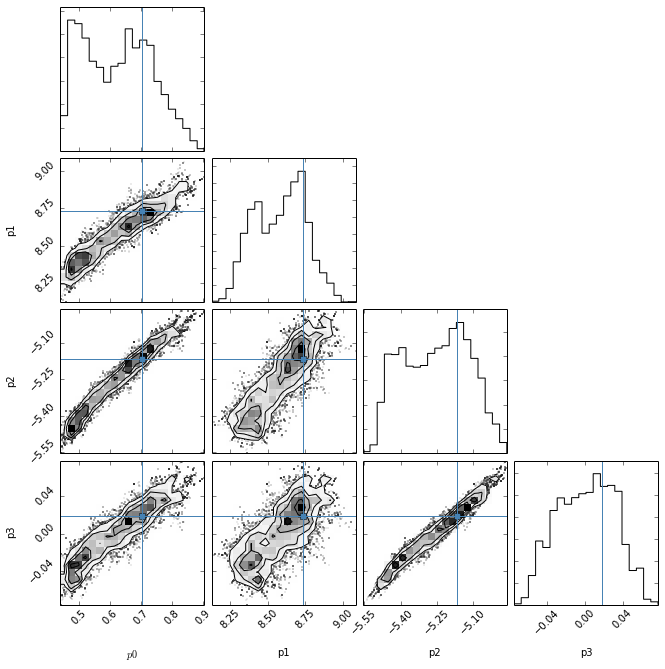

In [15]:
import corner
#p = [ 0.6797052,   8.64475999, -5.17048789,  0.02135271]
fig = corner.corner(samples, labels=["$p0$", "p1", "p2", "p3"],
                      truths=best_fit)

In [16]:
lnlike_ind(init_params,xval,yval, yval), lnlike_ind(best_fit,xval,yval, yval)

(-78.227968039392508, -19.453318271555524)

## Based on MCMC samples, build covariance and correlation matrix

In [17]:
modelMatrix=np.empty([samples.shape[0], xval.size])
for i,s in enumerate(samples):
    modelMatrix[i,:]= model2_CDF2009(xval,s)
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

[]

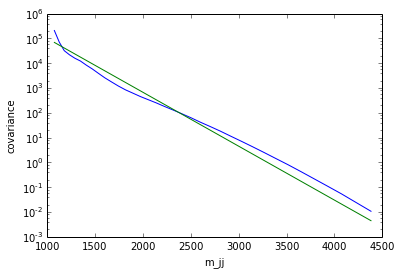

In [18]:
#Plot the variance vs. m_jj
plt.plot(xval,np.diagonal(covMat), c='b')
decay = 200
plt.plot(xval, 1e5*np.exp(-(xval-1000)/decay), c='g') # basic "fit" to the variance vs. m_jj
plt.ylabel('covariance')
plt.xlabel('m_jj')
plt.semilogy()

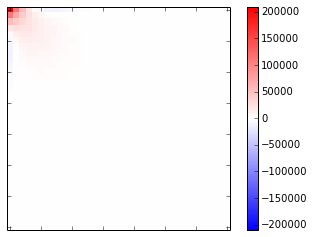

In [19]:
#plot covariance matrix
crop=0
maxVal = covMat[crop,crop]
plt.imshow(covMat[crop:,crop:], cmap="bwr",vmin=-maxVal, vmax=maxVal, interpolation="nearest")
plt.colorbar()
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([]);

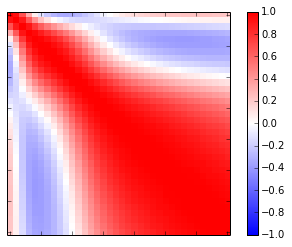

In [20]:
#plot correlation matrix
plt.imshow(corMat, cmap='bwr', vmin=-1, interpolation="nearest")
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.colorbar();

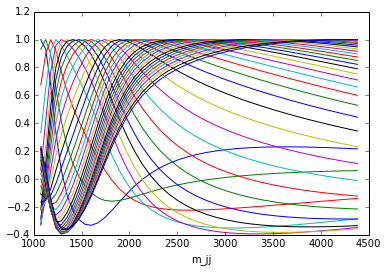

In [21]:
#plot values for rows of correlation vs. m_jj
for i in range(xval.size):
    plt.plot(xval,corMat[i,:])
plt.xlabel("m_jj");

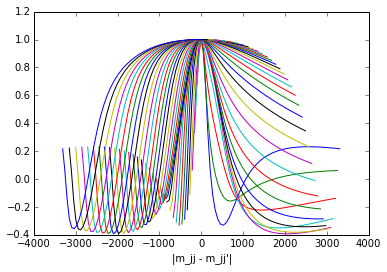

In [22]:
#plot correlation vs. |m_jj - m_jj'|
for i in range(xval.size):
    plt.plot(xval-xval[i],corMat[i,:])
plt.xlabel("|m_jj - m_jj'|");

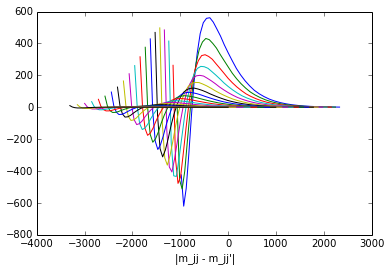

In [23]:
#plot covariance vs. |m_jj - m_jj'|, exclude the first ones that are huge
for i in range(15,xval.size):
    plt.plot(xval-xval[i],covMat[i,:])
plt.xlabel("|m_jj - m_jj'|");

## Model the covariance

In [24]:
import george
from george.kernels import ExpSquaredKernel, MyDijetKernel

The kernel is defined using the new george yml approach
http://dan.iel.fm/george/dev/tutorials/new_kernel/

**First try MyDijetKernel**

The key part is this:
```
value: |
    double xbar = 0.5*(std::abs(x1) + std::abs(x2));
    double r = std::abs(x1-x2); 
    return exp(-xbar/a) * exp(-r*r/b/b);
```

#Try with Gaussian Process

two different notions of what the GP is describing.
   * the GP kernel has a diagonal piece yerr=sqrt(yval) that describes the independent bin-by-bin Poisson fluctuations. In this case, we would fit the actual data and should expect the GP to bounce around a lot b/c it's describing both statistical fluctuations and how the mean moves around
   
   * we use the GP to describe the mean, so it should be very smooth. Then the yerr part shoudl basically be zero. In this case we don't fit the data, but the diferent mean itself. To start with this we could try to fit the different samples of the CDF fit function or some Monte Carlo samples. 

The first approach can still work when we add a signal component b/c any deviation bigger than the bin-by-bin Poisson fluctuations and the flexibility of the GP kernel will be ascribed to the new signal.
  

In [25]:
example_residual_model = best_fit_model-model2_CDF2009(xval,samples[1])

In [26]:
kernel = 500/np.exp(-1200/decay)*MyDijetKernel(a=decay,b=100)
#kernel = 500*ExpSquaredKernel(50)
gp = george.GP(kernel)
# Pre-compute the factorization of the matrix.
gp.compute(xval,yerr=10)

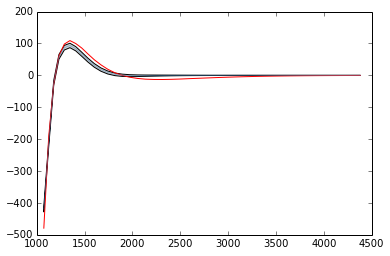

In [27]:
meanGP, covGP = gp.predict(example_residual_model, xval)
stdGP = np.sqrt(np.diag(covGP))
pl.plot(xval, example_residual_model, c='r')
pl.plot(xval, meanGP, color="#4682b4", alpha=0.5)
plt.fill_between(xval,meanGP-stdGP,meanGP+stdGP,facecolor='lightgray')

In [28]:
# want a non-stationary kernel where the amplitude 

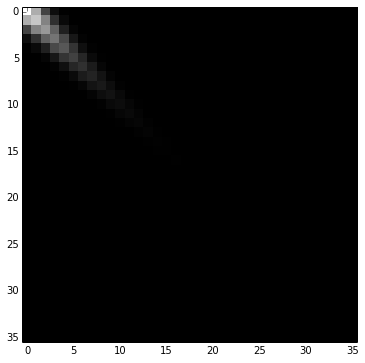

In [29]:
k = kernel.get_value(np.atleast_2d(xval).T)
plt.figure(figsize=(6, 6))
plt.imshow(k, cmap="gray", interpolation="nearest")
#plt.gca().set_xticklabels([])
#plt.gca().set_yticklabels([]);

### Fit to data residual with yerr=sqrt(y)

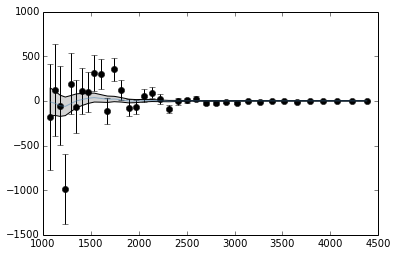

In [30]:
kernel = 15000/np.exp(-1200/decay)*MyDijetKernel(a=decay,b=100)
gp = george.GP(kernel)

data_residual = yval-model2_CDF2009(xval,samples[1])
gp.compute(xval,yerr=np.sqrt(yval))
meanGP, covGP = gp.predict(data_residual, xval)
stdGP = np.sqrt(np.diag(covGP))
#pl.plot(xval, data_residual, c='r')
plt.errorbar(xval,data_residual,marker='o',ls='None', yerr=np.sqrt(yval),c='black')
pl.plot(xval, meanGP, color="#4682b4", alpha=0.5)
plt.fill_between(xval,meanGP-stdGP,meanGP+stdGP,facecolor='lightgray')

### Do MCMC with CDF model as mean of GP

In [31]:
def lnprob_gp(p, x, y, yerr): 
    decay = 200
    kernel = 15000/np.exp(-1200/decay)*MyDijetKernel(a=decay,b=100)
    gp = george.GP(kernel)
    gp.compute(x, yerr)
    gpl = gp.lnlikelihood(y - model2_CDF2009(x,p))
    return gpl 

In [32]:
def fit_gp(initial, data, nwalkers=32):
    ndim = len(initial)
    p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gp, args=data)
    print("Running burn-in")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()
    
    best_fit = p0[np.argmax(lnp)]
    print best_fit

    #print("Running second burn-in")
    #p = p0[np.argmax(lnp)]
    #p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
    #p0, _, _ = sampler.run_mcmc(p0, 500)
    #sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)
    return sampler, best_fit

In [33]:
np.random.seed(1234)
init_params = best_fit
data = (xval, yval, np.sqrt(yval))

# Fit assuming GP.
print("Fitting gp")
sampler, best_fit = fit_gp(init_params, data)
samples = sampler.flatchain

Fitting gp
Running burn-in
[ 0.86600782  8.90666434 -5.00591501  0.05262614]
Running production


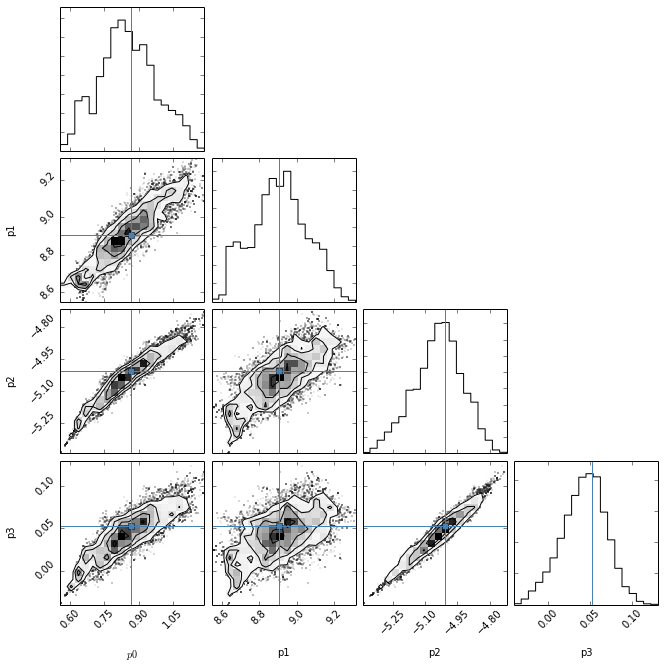

In [34]:
fig = corner.corner(samples, labels=["$p0$", "p1", "p2", "p3"],
                      truths=best_fit)

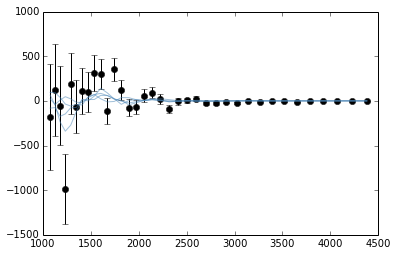

In [35]:
plt.errorbar(xval,data_residual,marker='o',ls='None', yerr=np.sqrt(yval),c='black')
for s in samples[20]:
    kernel = 15000/np.exp(-1200/decay)*MyDijetKernel(a=decay,b=100)
    gp = george.GP(kernel)
    gp.compute(xval, yerr=np.sqrt(yval))
    meanGP = gp.sample_conditional(data_residual, xval)
    pl.plot(xval, meanGP, color="#4682b4", alpha=0.5)

[]

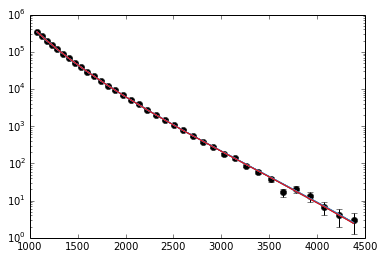

In [36]:
plt.errorbar(xval,yval,marker='o',ls='None', yerr=np.sqrt(yval),c='black')
for s in samples[:20]:
    kernel = 15000/np.exp(-1200/decay)*MyDijetKernel(a=decay,b=100)
    gp = george.GP(kernel)
    gp.compute(xval, yerr=np.sqrt(yval))
    meanGP = gp.sample_conditional(data_residual, xval) + model2_CDF2009(xval,s)
    pl.plot(xval, meanGP, color="#4682b4", alpha=0.5)
plt.plot(xval, model2_CDF2009(xval,best_fit), c='r')
plt.semilogy()

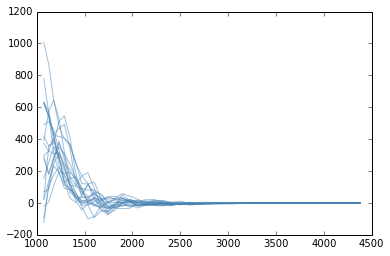

In [37]:
for s in samples[:20]:
    kernel = 15000/np.exp(-1200/decay)*MyDijetKernel(a=decay,b=100)
    gp = george.GP(kernel)
    gp.compute(xval, yerr=np.sqrt(yval))
    meanGP = gp.sample_conditional(data_residual, xval) + model2_CDF2009(xval,s)
    pl.plot(xval,  model2_CDF2009(xval,best_fit)-meanGP, color="#4682b4", alpha=0.5)

## Inject a signal see how it goes

In [38]:
def sig_model(x, N=500., mass=3000., width=100.):
    return N*np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width*(xerrplus+xerrminus)

In [39]:
fake_data = yval+sig_model(xval)

[]

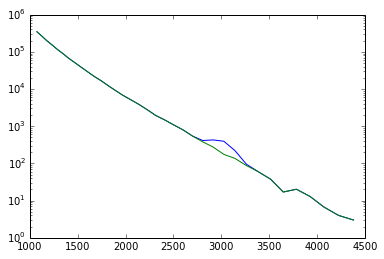

In [40]:
plt.plot(xval,fake_data)
plt.plot(xval,yval)
plt.semilogy()

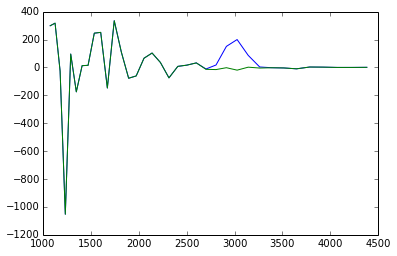

In [41]:
plt.plot(xval,fake_data-best_fit_model)
plt.plot(xval,yval-best_fit_model)

In [42]:
fake_data_residual = fake_data-model2_CDF2009(xval,samples[1])

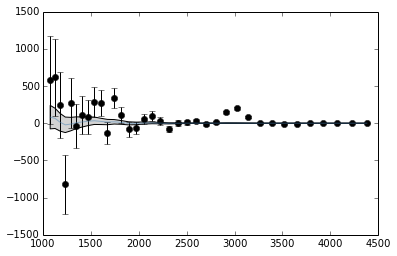

In [43]:
# do a GP fit to the fake data residual
# note, the GP cannot fill in the signal near 3000 GeV
kernel = 15000/np.exp(-1200/decay)*MyDijetKernel(a=decay,b=100)
gp = george.GP(kernel)
gp.compute(xval,yerr=np.sqrt(fake_data))
meanGP, covGP = gp.predict(fake_data_residual, xval)
stdGP = np.sqrt(np.diag(covGP))
#pl.plot(xval, data_residual, c='r')
plt.errorbar(xval,fake_data_residual,marker='o',ls='None', yerr=np.sqrt(fake_data),c='black')
pl.plot(xval, meanGP, color="#4682b4", alpha=0.5)
plt.fill_between(xval,meanGP-stdGP,meanGP+stdGP,facecolor='lightgray')

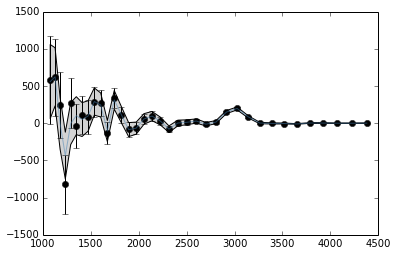

In [44]:
# do a GP fit to the fake data residual
# this time have the exponential decay of the amplitude of the covariance 
# extended by a factor of 5
# note, the GP now CAN fill in the signal near 3000 GeV
# this shows that the nominal model for the GP above is powerful
# but we can't let the hyperparameters of the kernel be out of control
# or the GP will fit the signal

kernel = 15000/np.exp(-1200/decay)*MyDijetKernel(a=5*decay,b=100)
gp = george.GP(kernel)

fake_data_residual = fake_data-model2_CDF2009(xval,samples[1])
gp.compute(xval,yerr=np.sqrt(fake_data))
meanGP, covGP = gp.predict(fake_data_residual, xval)
stdGP = np.sqrt(np.diag(covGP))
#pl.plot(xval, data_residual, c='r')
plt.errorbar(xval,fake_data_residual,marker='o',ls='None', yerr=np.sqrt(fake_data),c='black')
pl.plot(xval, meanGP, color="#4682b4", alpha=0.5)
plt.fill_between(xval,meanGP-stdGP,meanGP+stdGP,facecolor='lightgray')

In [45]:
def sig_cdf(t, params): 
    global xerrplus, xerrminus
    p0, p1, p2, p3, N, mass, width = params
    sqrts = 8000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2+p3*np.log(t/sqrts)) \
            + N*np.exp(-(t-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)\
            *(xerrplus+xerrminus)

In [46]:
def lnprior_signal(p):
    N, mass, width = p
    if (0 < N < 3000 and  1000 < mass < 4500 and 20 < width < 1000 ):
        return 0.0
    return -np.inf

In [47]:
def lnprob_gp_with_sig(p, x, y, yerr): 
    decay = 200
    kernel = 15000/np.exp(-1200/decay)*MyDijetKernel(a=decay,b=100)
    gp = george.GP(kernel)
    gp.compute(x, yerr)
    gpl = gp.lnlikelihood(y - sig_cdf(x,p))
    return gpl 

In [48]:
def fit_gp_with_sig(initial, data, nwalkers=32):
    ndim = len(initial)
    p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gp_with_sig, args=data)
    print("Running burn-in")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()
    
    best_fit = p0[np.argmax(lnp)]
    print best_fit

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)
    return sampler, best_fit

In [49]:
np.random.seed(1234)
init_params = np.hstack((best_fit,[200, 3000, 100]))
data = (xval, fake_data, np.sqrt(fake_data))

# Fit assuming GP.
print("Fitting gp")
sampler, best_fit_with_sig = fit_gp_with_sig(init_params, data)
samples = sampler.flatchain

Fitting gp
Running burn-in
[  8.20697060e-01   8.66994700e+00  -4.96057225e+00   8.05462654e-02
   1.99047360e+02   3.00341642e+03   9.34115046e+01]
Running production


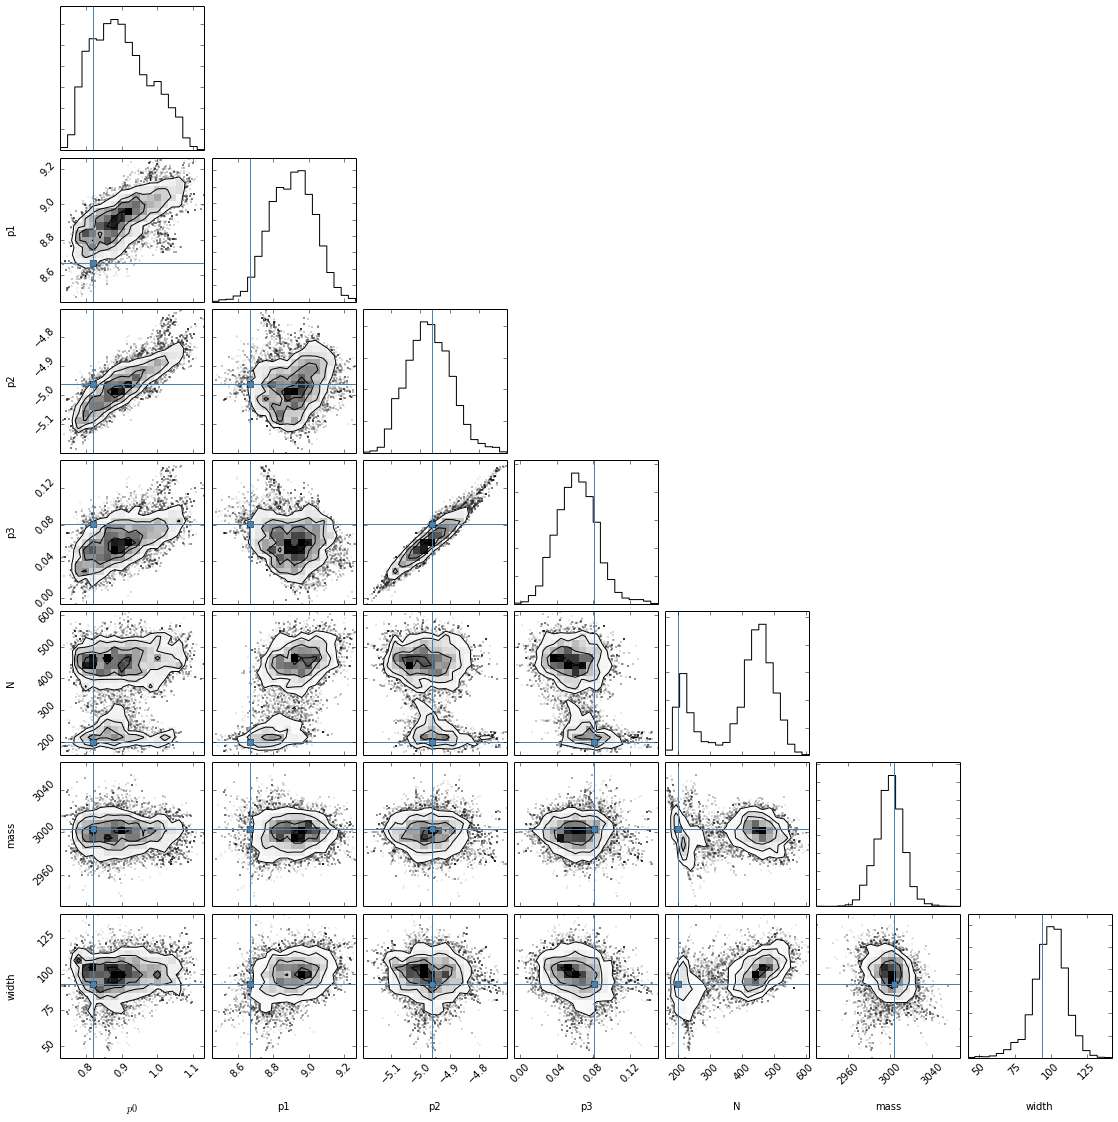

In [60]:
fig = corner.corner(samples, labels=["$p0$", "p1", "p2", "p3",'N', 'mass', 'width'],
                      truths=best_fit_with_sig)

(10, 1500)

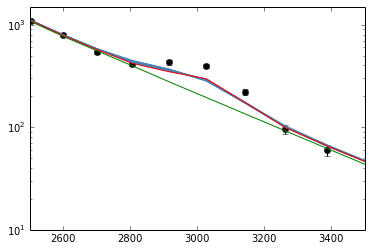

In [62]:
plt.errorbar(xval,fake_data,marker='o',ls='None', yerr=np.sqrt(fake_data),c='black')
for s in samples[:20]:
    kernel = 15000/np.exp(-1200/decay)*MyDijetKernel(a=decay,b=100)
    gp = george.GP(kernel)
    gp.compute(xval, yerr=np.sqrt(fake_data))
    meanGP = gp.sample_conditional(fake_data_residual, xval) + sig_cdf(xval,s)
    pl.plot(xval, meanGP, color="#4682b4", alpha=0.5)
plt.plot(xval, sig_cdf(xval,best_fit_with_sig), c='r')
bkg_only_params = np.hstack((best_fit,[0, 3000, 100]))
plt.plot(xval, sig_cdf(xval,bkg_only_params), c='g')
plt.semilogy()
plt.xlim(2500,3500)
plt.ylim(10,1500)